# Fill Missing Values

In [1]:
# IMPORTANT: used data wrangler(GUI) extension for data cleaning, after I performed actions using data wrangler GUI, it generated code for steps i performed, almost all comments and code is generated after steps conversion

# Loaded variable 'df' from kernel state

# in this dataset many missing values mean no existence

# Replace missing values with "NA" in column: 'Pool QC'
import pandas as pd
import numpy as np

df = pd.read_csv("../ames_housing_dataset.csv")
df = df.fillna({"Pool QC": "NA"})

# Replace missing values with "NA" in column: 'Misc Feature'
df = df.fillna({"Misc Feature": "NA"})

# Replace missing values with "NA" in column: 'Fence'
df = df.fillna({"Fence": "NA"})

# Update garage-related columns where Garage Area is 0, since it mean garage doesn't exist
df.loc[
    df["Garage Area"] == 0,
    ["Garage Type", "Garage Yr Blt", "Garage Finish", "Garage Qual", "Garage Cond"],
] = ["NA", 0, "NA", "NA", "NA"]

# Replace remaining missing values of 'Garage Yr Blt' with 'Year Built':
df["Garage Yr Blt"] = df["Garage Yr Blt"].fillna(df["Year Built"])

# found weird value
df.loc[df["Garage Yr Blt"] == 2207, "Garage Yr Blt"] = 1977  # median

# Replace remaining values with the mean/mode each remaining garage related column
df = df.fillna({"Garage Cond": df["Garage Cond"].mode()[0]})
df = df.fillna({"Garage Qual": df["Garage Qual"].mode()[0]})
df = df.fillna({"Garage Area": df["Garage Area"].mean()})
df = df.fillna({"Garage Cars": df["Garage Cars"].mode()[0]})
df = df.fillna({"Garage Finish": df["Garage Finish"].mode()[0]})

# fixing order 1342

# Filter rows where Order = 1342
df.loc[df["Order"] == 1342, "BsmtFin SF 2"] = 0  # Set BsmtFin SF 2 to 0
# Calculate averages
bsmt_unf_sf_avg = df["Bsmt Unf SF"].mean()
bsmtfin_sf1_avg = df["BsmtFin SF 1"].mean()
# Update columns with averages
df.loc[df["Order"] == 1342, "Bsmt Unf SF"] = bsmt_unf_sf_avg
df.loc[df["Order"] == 1342, "BsmtFin SF 1"] = bsmtfin_sf1_avg
df.loc[df["Order"] == 1342, "Total Bsmt SF"] = bsmt_unf_sf_avg + bsmtfin_sf1_avg
# Calculate modes
bsmt_qual_mode = df["Bsmt Qual"].mode()[0]
bsmt_cond_mode = df["Bsmt Cond"].mode()[0]
bsmt_exposure_mode = df["Bsmt Exposure"].mode()[0]
bsmtfin_type1_mode = df["BsmtFin Type 1"].mode()[0]
# Update columns with modes
df.loc[df["Order"] == 1342, "Bsmt Qual"] = bsmt_qual_mode
df.loc[df["Order"] == 1342, "Bsmt Cond"] = bsmt_cond_mode
df.loc[df["Order"] == 1342, "Bsmt Exposure"] = bsmt_exposure_mode
df.loc[df["Order"] == 1342, "BsmtFin Type 1"] = bsmtfin_type1_mode
# Set BsmtFin Type 2 to 'Unf'
df.loc[df["Order"] == 1342, "BsmtFin Type 2"] = "Unf"

# Update Bsmt Exposure to 'No' where BsmtFin Type 1 and BsmtFin Type 2 are 'Unf'
df.loc[
    (df["BsmtFin Type 1"] == "Unf") & (df["BsmtFin Type 2"] == "Unf"), "Bsmt Exposure"
] = "No"

# Update BsmtFin Type 2 to 'Rec'(2nd to Unf) where Order is 445, since it was just missing this cell
df.loc[df["Order"] == 445, "BsmtFin Type 2"] = "Rec"

# Replace missing values with 'NA' in specified columns
df[["Bsmt Qual", "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2"]] = (
    df[
        ["Bsmt Qual", "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2"]
    ].fillna("NA")
)

# Replace missing values with 0 in column: 'Bsmt Full Bath'
df = df.fillna({"Bsmt Full Bath": 0})

# Replace missing values with 0 in column: 'Bsmt Half Bath'
df = df.fillna({"Bsmt Half Bath": 0})

# Replace missing values with "SBrkr" (mode) in column: 'Electrical'
df = df.fillna({"Electrical": "SBrkr"})

# Replace missing values with "NA" in column: 'Fireplace Qu'
df = df.fillna({"Fireplace Qu": "NA"})

# Replace missing values with "NA" in column: 'Fireplace Qu'
df = df.fillna({"Alley": "NA"})

# 'Mas Vnr Area' have 0's and missing values too
# Update 'Mas Vnr Type' with mode where 'Mas Vnr Area' is missing
mode_value = df["Mas Vnr Type"].mode()[0]
df.loc[df["Mas Vnr Area"].isnull(), "Mas Vnr Type"] = mode_value

# Replace missing values with the mean of each column in: 'Mas Vnr Area'
df = df.fillna({"Mas Vnr Area": df["Mas Vnr Area"].mean()})

# Now missing values in 'Mas Vnr Type' only exist besides 0's in 'Mas Vnr Area' (no veneer)

# Replace missing values with "NA" in column: 'Mas Vnr Type'
df = df.fillna({"Mas Vnr Type": "NA"})

# predicting 'lot frontage' missing values with 'Lot Area', 'Lot Shape', 'Lot Config'

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Only rows with known Lot Frontage
df_known = df[df["Lot Frontage"].notnull()]
df_unknown = df[df["Lot Frontage"].isnull()]

features = ["Lot Area", "Lot Shape", "Lot Config"]

# Model pipeline
pipe = Pipeline(
    [
        (
            "pre",
            ColumnTransformer(
                [("cat", OneHotEncoder(), ["Lot Shape", "Lot Config"])],
                remainder="passthrough",
            ),
        ),
        ("lr", LinearRegression()),
    ]
)

pipe.fit(df_known[features], df_known["Lot Frontage"])

# Predict missing values
df.loc[df["Lot Frontage"].isnull(), "Lot Frontage"] = pipe.predict(df_unknown[features])


###########################################################
# adjusting data types

for col in df.select_dtypes(include="float").columns:
    if np.all(df[col].dropna() == df[col].dropna().astype(int)):
        df[col] = df[col].astype("Int64")  # Use nullable Int64 to preserve NaNs

# Change column type to int64 for column: 'Lot Frontage'
df = df.astype({"Lot Frontage": "int64"})

# Change column type to int64 for column: 'Garage Area'
df = df.astype({"Garage Area": "int64"})

# Change column type to int64 for column: 'Garage Yr Blt'
df = df.astype({"Garage Yr Blt": "int64"})

# Change column type to int64 for column: 'Bsmt Half Bath'
df = df.astype({"Bsmt Half Bath": "int64"})

# Change column type to int64 for column: 'Bsmt Full Bath'
df = df.astype({"Bsmt Full Bath": "int64"})

# Change column type to int64 for column: 'Bsmt Unf SF'
df = df.astype({"Bsmt Unf SF": "int64"})

# Change column type to int64 for column: 'BsmtFin SF 2'
df = df.astype({"BsmtFin SF 2": "int64"})

# Change column type to int64 for column: 'BsmtFin SF 1'
df = df.astype({"BsmtFin SF 1": "int64"})

# Change column type to int64 for column: 'Mas Vnr Area'
df = df.astype({"Mas Vnr Area": "int64"})

###########################################################
# selecting and adusting columns

df.columns = df.columns.str.replace(" ", "")
# we wont need the ordrer column
df.drop("Order", axis=1, inplace=True)
df = df.drop(columns=["PID"])

df


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,20,RL,141,31770,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,20,RH,80,11622,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,20,RL,81,14267,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,20,RL,93,11160,Pave,NA,Reg,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,60,RL,74,13830,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,RL,37,7937,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,0,NA,GdPrv,NA,0,3,2006,WD,Normal,142500
2926,20,RL,70,8885,Pave,NA,IR1,Low,AllPub,Inside,...,0,NA,MnPrv,NA,0,6,2006,WD,Normal,131000
2927,85,RL,62,10441,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,20,RL,77,10010,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,4,2006,WD,Normal,170000


# Remove Outliers

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
 
cols = df.select_dtypes(include=np.number).columns[0:]
cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemod/Add', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

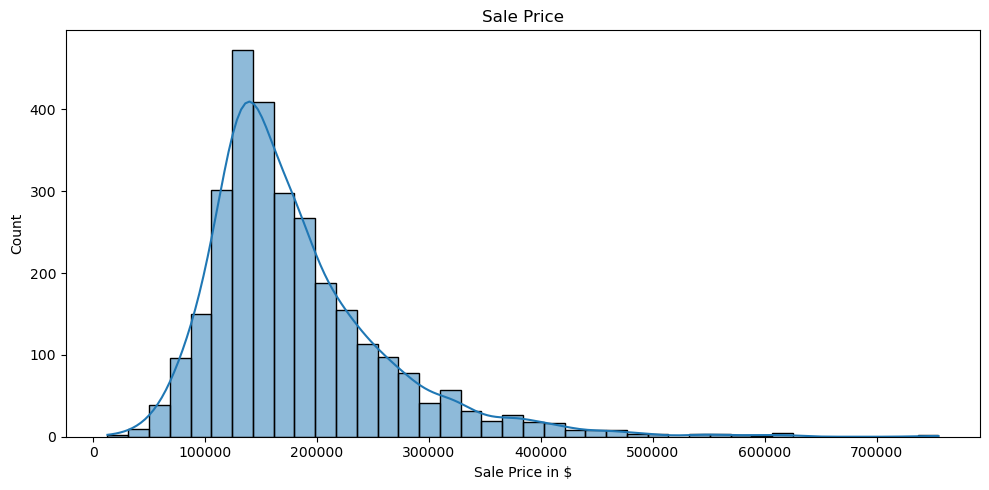

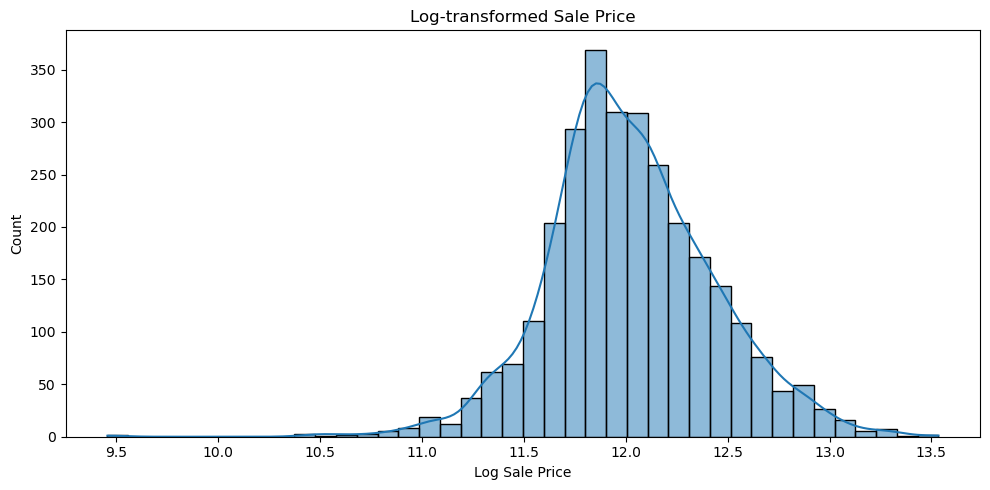

In [3]:
# Set color palette
palette = sns.color_palette('viridis', 5)

# Plot 1: Sale Price
plt.figure(figsize=(10, 5))
sns.histplot(df.SalePrice, bins=40, kde=True)
plt.title('Sale Price')
plt.xlabel('Sale Price in $')
plt.tight_layout()
plt.show()

# Plot 2: Log-transformed Sale Price
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(df.SalePrice), bins=40,kde=True)
plt.title('Log-transformed Sale Price')
plt.xlabel('Log Sale Price')
plt.tight_layout()
plt.show()

# Add log-transformed SalePrice to the DataFrame
df['logSalePrice'] = np.log1p(df['SalePrice'])

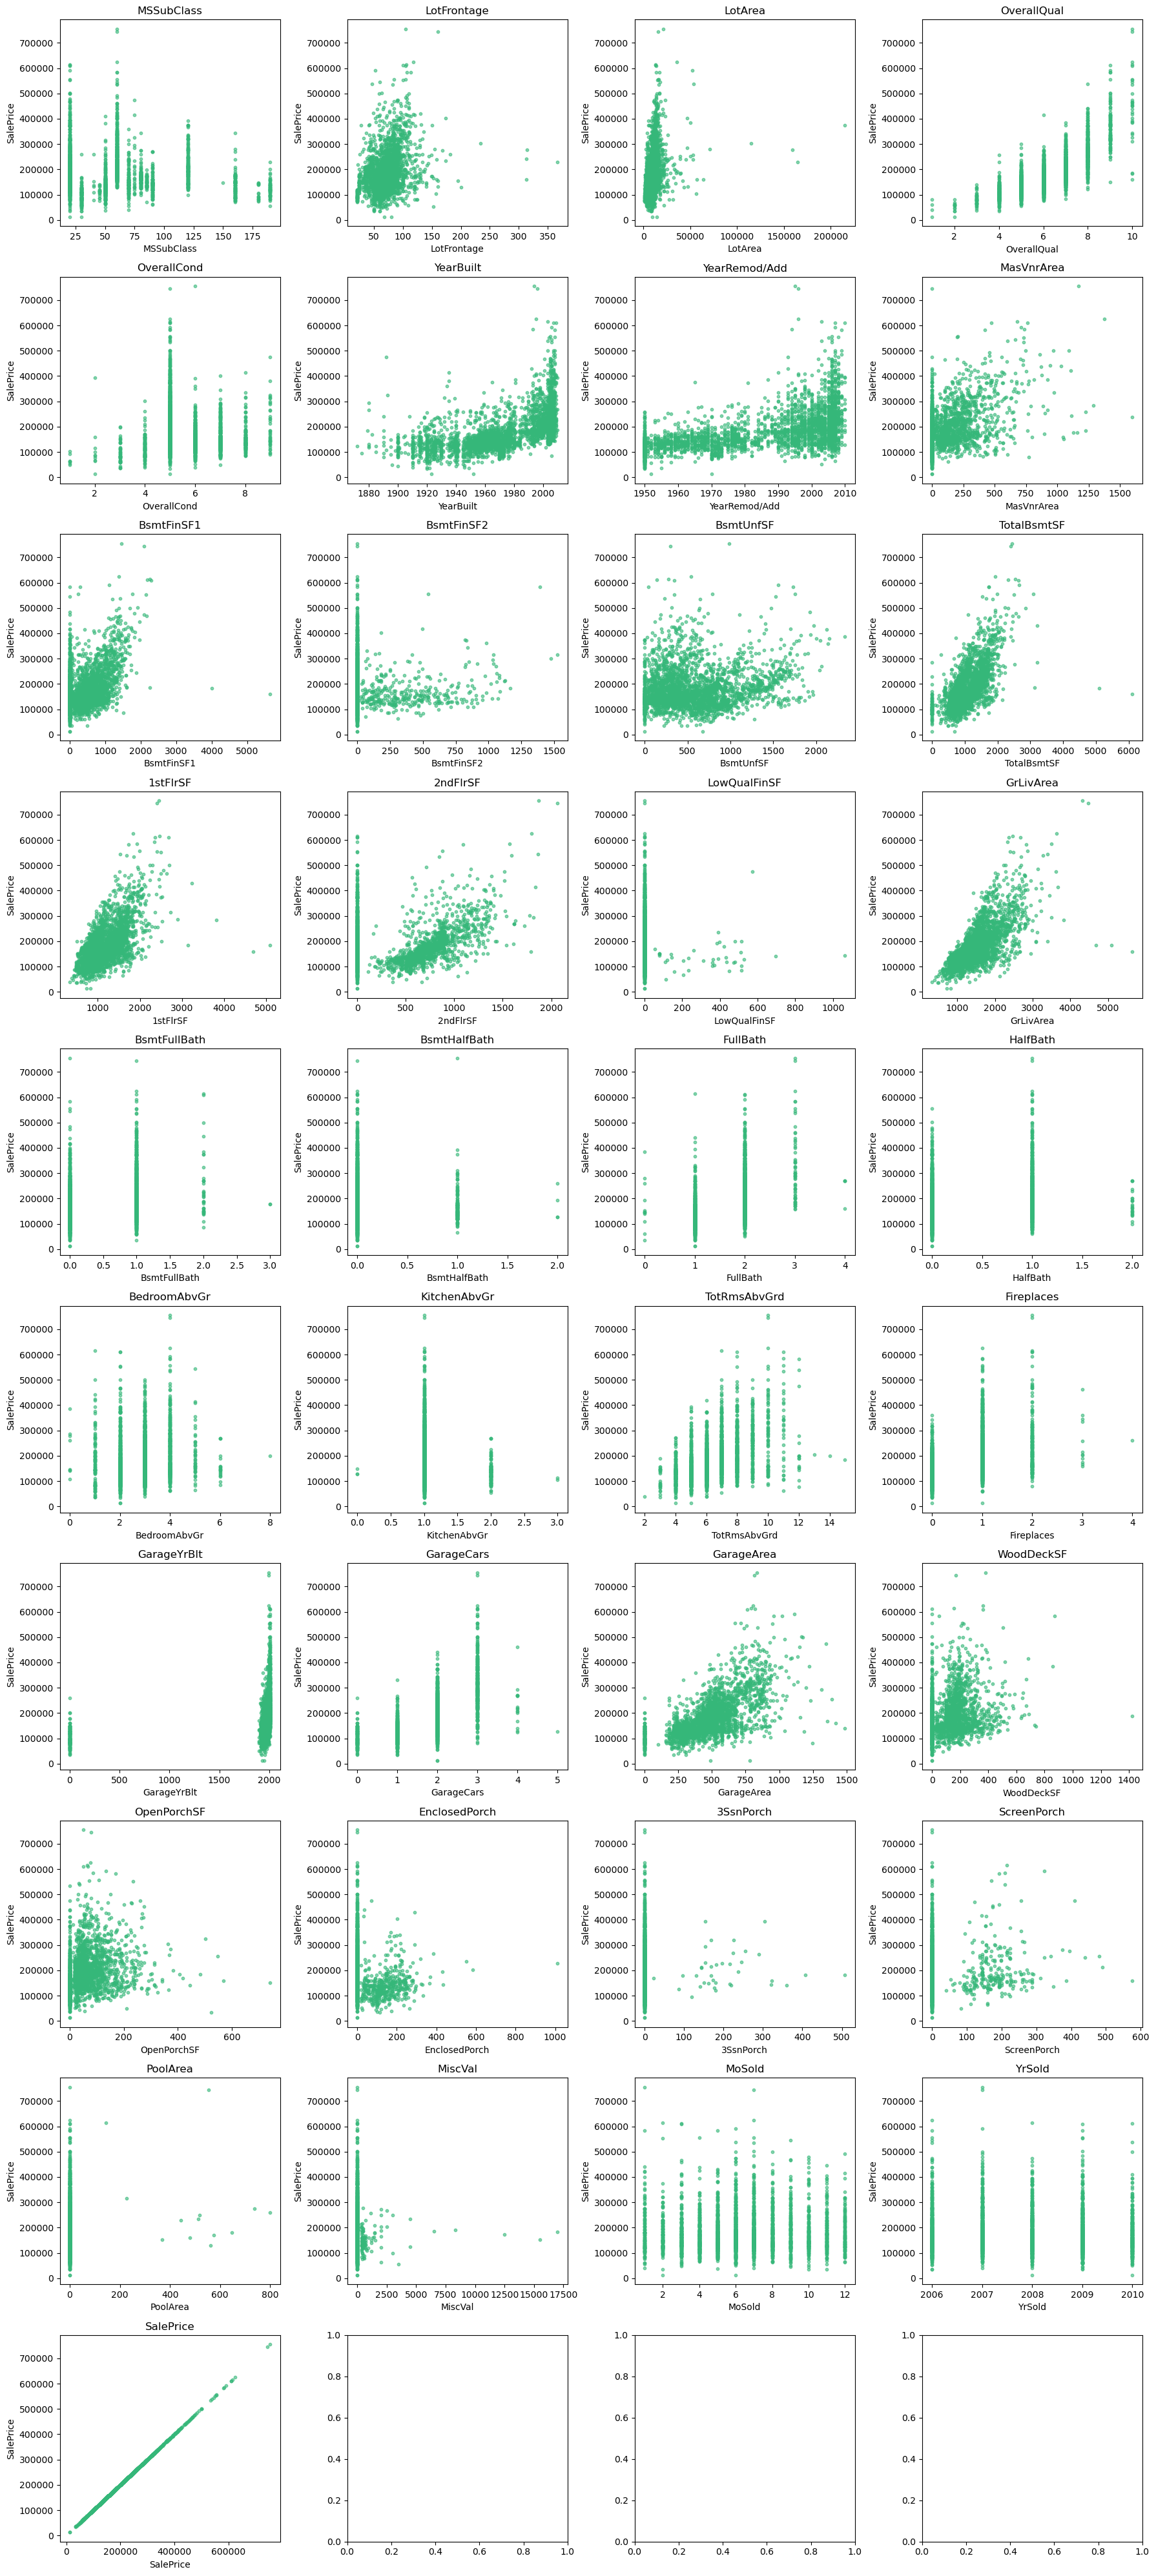

In [4]:
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(18, 40))  # Adjust height

for col, ax in zip(cols, axes.ravel()):
    ax.scatter(df[col], df.SalePrice, alpha=0.6, s=10, color=palette[3])
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("SalePrice")

plt.tight_layout()  
plt.show()     

In [5]:
# lot area and GrLivArea have few outliers
# for some ~5000 GrLivArea, Sale Price is ~150,000 (outlier) and ~3500 GrLivArea have Sale Price ~550,000 (normal) 

df.drop(df.loc[(df.GrLivArea > 4000)].index, inplace=True)

# LotArea outlier > 100,000, visible clearly
df.drop(df.loc[(df.LotArea > 100_000)].index, inplace=True)

# There are also two house under 20_000 in the sale price, which seems unsual
df.drop(df.loc[(df.SalePrice < 20000)].index, inplace=True)

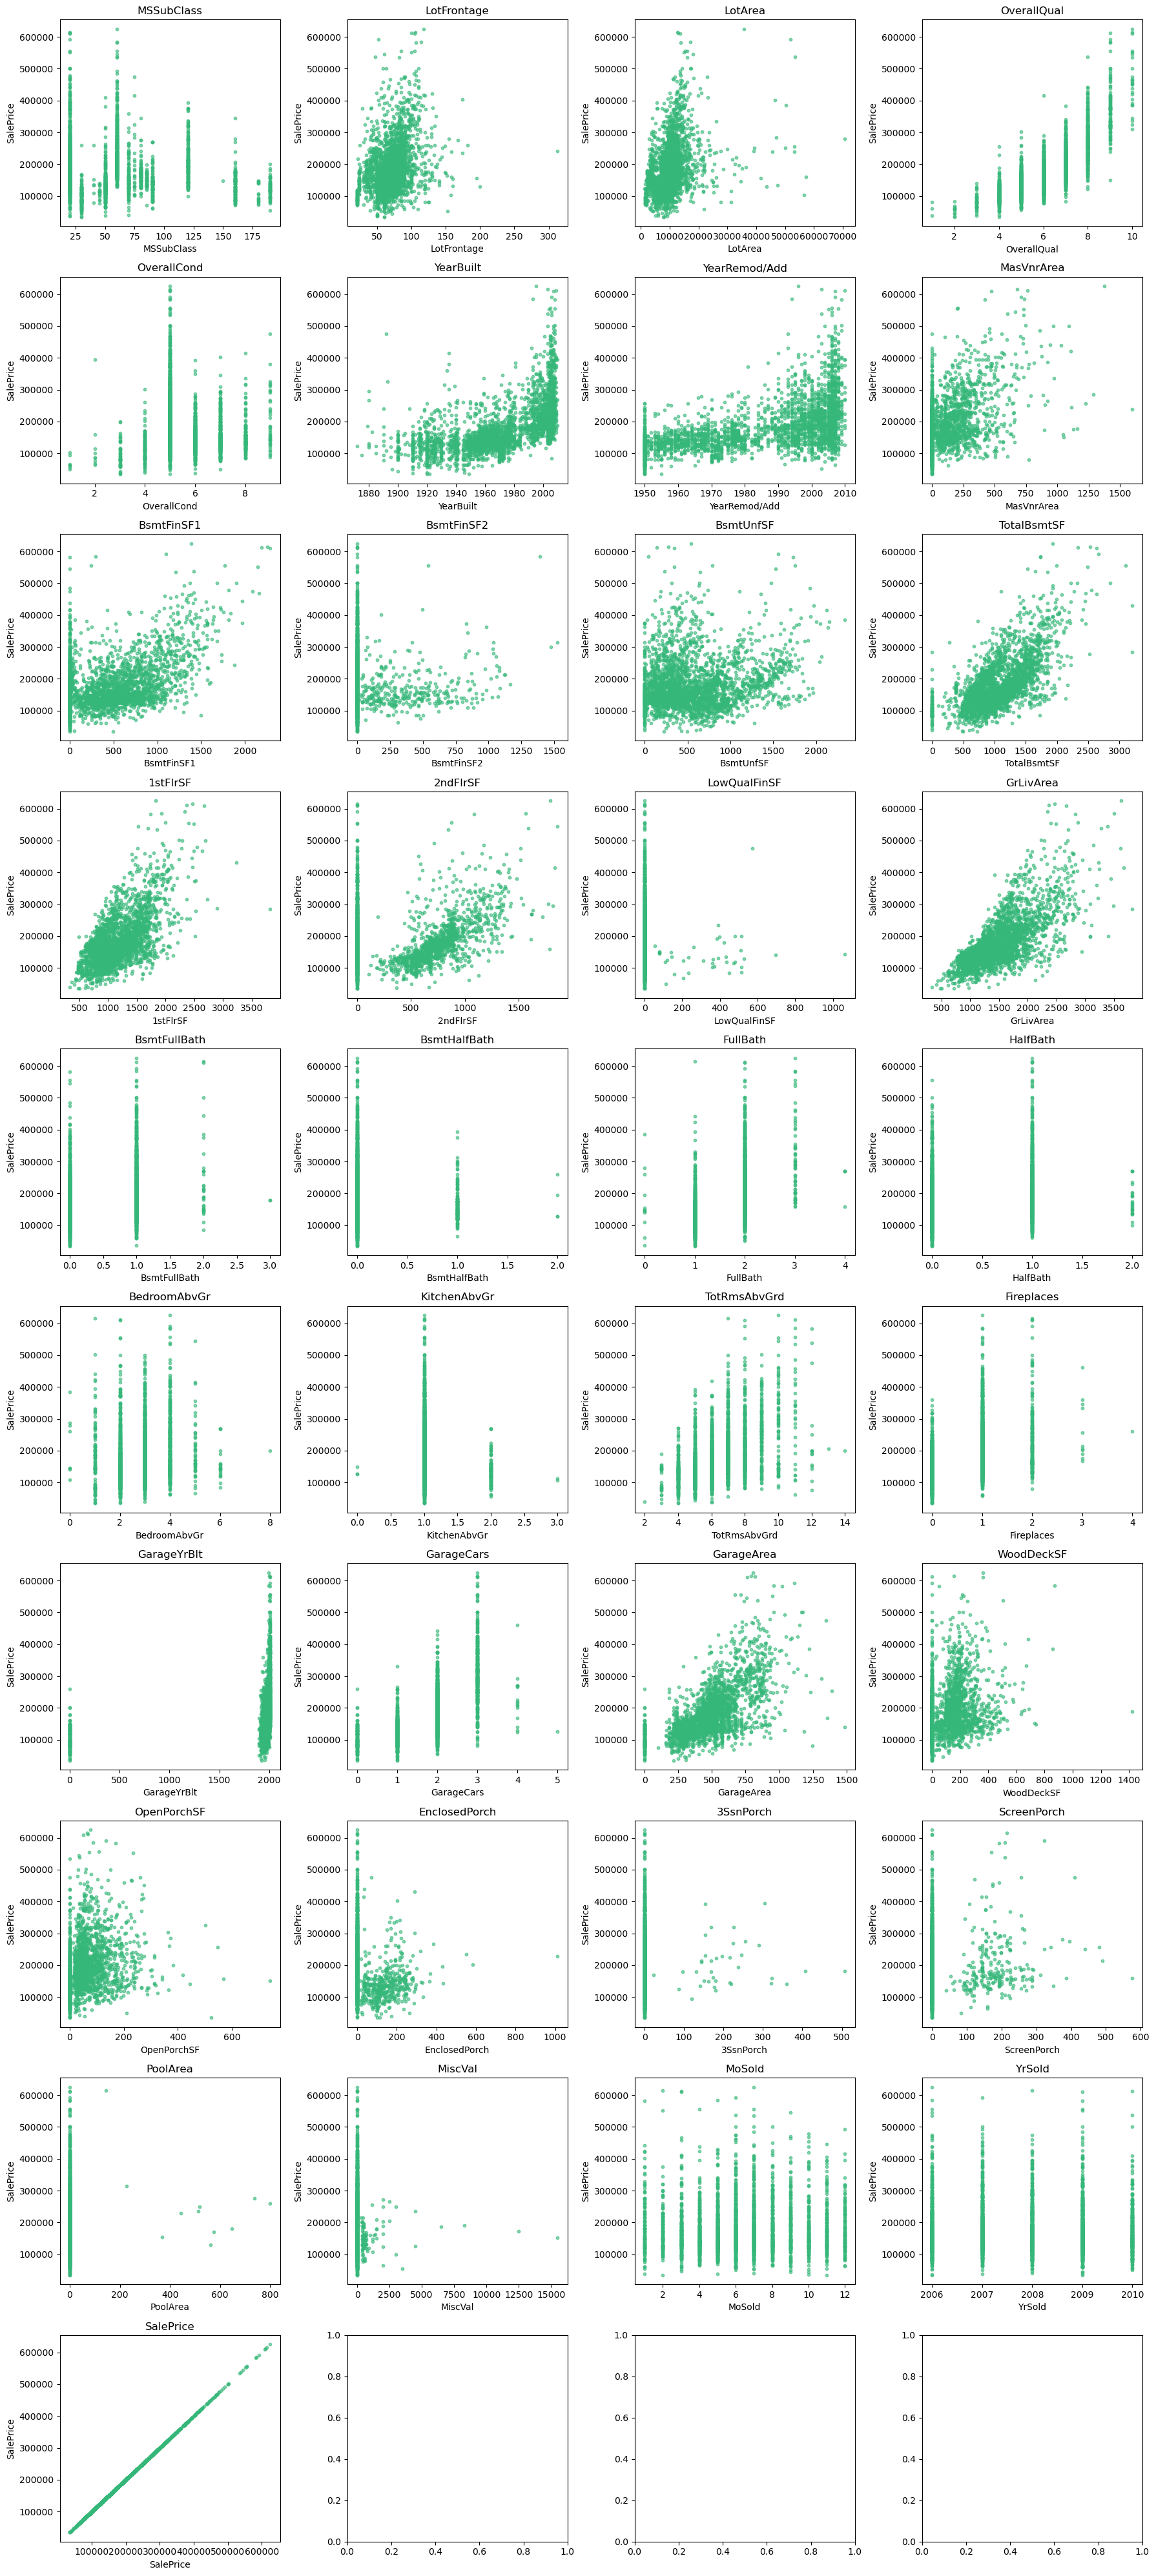

In [6]:
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(18, 40))  # Adjust height

for col, ax in zip(cols, axes.ravel()):
    ax.scatter(df[col], df.SalePrice, alpha=0.6, s=10, color=palette[3])
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("SalePrice")

plt.tight_layout()  
plt.show()          

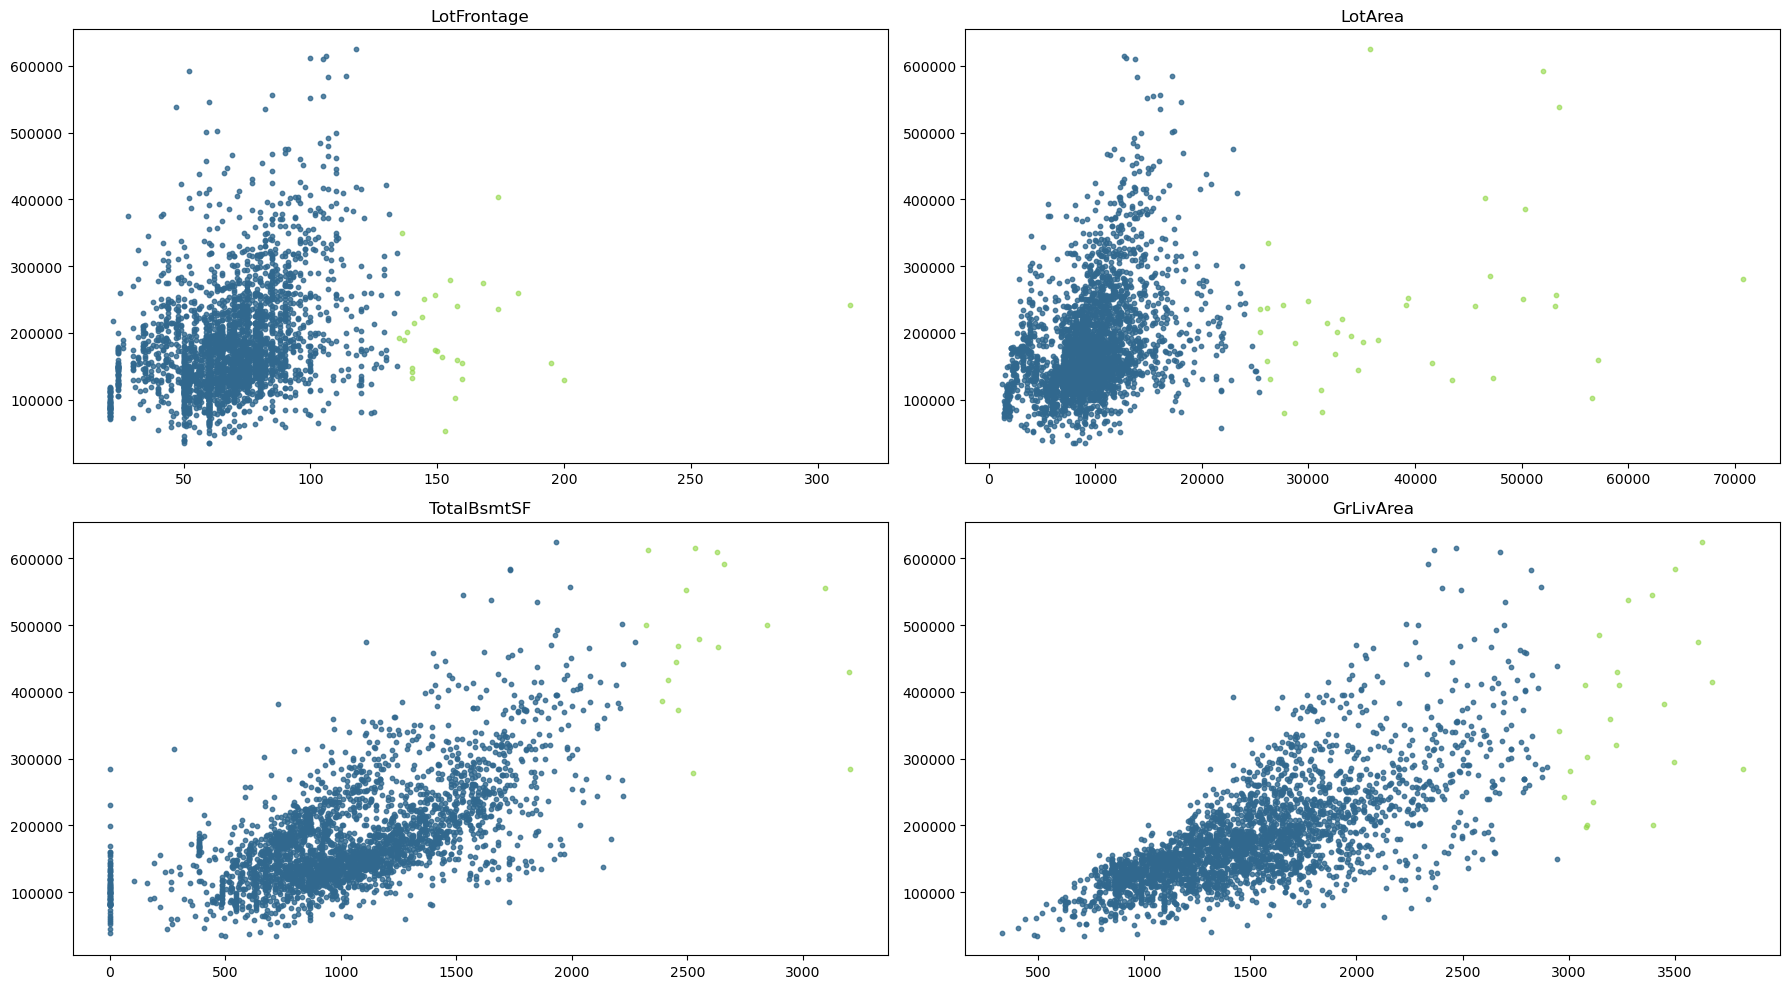

In [7]:
 
cols = ['LotFrontage', 'LotArea', 'TotalBsmtSF', 'GrLivArea']
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 2*5))

for col, ax in zip(cols, axes.ravel()):
    zscores = (df[col] - df[col].mean()) / (df[col].std())
    x_zscores = np.abs(zscores) > 3
    ax.scatter(df.loc[x_zscores, col], df.loc[x_zscores, 'SalePrice'], alpha=0.6, s=10, color=palette[4])
    ax.scatter(df.loc[~x_zscores, col], df.loc[~x_zscores, 'SalePrice'], alpha=0.8, s=10, color=palette[1])
    ax.set_title(col)
plt.tight_layout()  
plt.show()       

In [8]:
# those from the LotArea feature will ipact the correlation, lets see how many there are
zscores = (df['LotArea'] - df['LotArea'].mean()) / (df['LotArea'].std())
x_zscores = np.abs(zscores) > 3

# 38 of them, lets remove them, I think these will be the only ones as the other variables have good correlation with theirs
df.drop(df.loc[x_zscores].index, inplace=True)

df.shape # (2881, 81)

(2881, 81)

In [9]:
df.drop(columns=['logSalePrice'], inplace=True) # it is not needed anymore  
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,20,RH,80,11622,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,20,RL,81,14267,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,20,RL,93,11160,Pave,NA,Reg,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,60,RL,74,13830,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900
5,60,RL,78,9978,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,6,2010,WD,Normal,195500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,RL,37,7937,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,0,NA,GdPrv,NA,0,3,2006,WD,Normal,142500
2926,20,RL,70,8885,Pave,NA,IR1,Low,AllPub,Inside,...,0,NA,MnPrv,NA,0,6,2006,WD,Normal,131000
2927,85,RL,62,10441,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,20,RL,77,10010,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,4,2006,WD,Normal,170000


# Feature Selection

In [10]:
df.drop(columns=['PavedDrive'], inplace=True) #Y 91%
df.drop(columns=['GarageYrBlt'], inplace=True) # almost same as YearBuilt
df.drop(columns=['Utilities'], inplace=True) #99% AllPub
df.drop(columns=['FireplaceQu'], inplace=True) # Fireplaces is already used, and is zero 1397 of times
df.drop(columns=['Heating'], inplace=True) # 98% GasA
df.drop(columns=['Condition1'], inplace=True) #86% Norm 
df.drop(columns=['Condition2'], inplace=True) #99% Norm

# Mostly 0 or "NA", so I drop it
df.drop(columns=['MiscVal'], inplace=True)
df.drop(columns=['MiscFeature'], inplace=True)
df.drop(columns=['PoolArea'], inplace=True)
df.drop(columns=['PoolQC'], inplace=True)
df.drop(columns=['3SsnPorch'], inplace=True)
df.drop(columns=['LowQualFinSF'], inplace=True)
df.drop(columns=['Fence'], inplace=True)

In [11]:
df.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.811355
GrLivArea        0.719650
TotalBsmtSF      0.659315
GarageCars       0.659255
GarageArea       0.656302
1stFlrSF         0.648739
YearBuilt        0.573452
FullBath         0.548060
YearRemod/Add    0.547636
MasVnrArea       0.503750
TotRmsAbvGrd     0.498036
Fireplaces       0.474438
BsmtFinSF1       0.436777
LotArea          0.395585
LotFrontage      0.366735
OpenPorchSF      0.325501
WoodDeckSF       0.323202
HalfBath         0.283097
BsmtFullBath     0.272473
2ndFlrSF         0.253119
BsmtUnfSF        0.191796
BedroomAbvGr     0.135810
ScreenPorch      0.104577
MoSold           0.037667
BsmtFinSF2       0.002900
YrSold          -0.024513
BsmtHalfBath    -0.047817
MSSubClass      -0.085950
OverallCond     -0.112959
KitchenAbvGr    -0.122575
EnclosedPorch   -0.134848
Name: SalePrice, dtype: float64

In [12]:
cols = ['LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'SalePrice']

correlations = df[cols].corr()['SalePrice']
correlations=correlations.sort_values(ascending=False)
print(correlations)

# 1stFlrSF + 2ndFlrSF = GrLivArea (high corr) 
# so better to choose GrLivArea than 1stFlrSF and 2ndFlrSF

# BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF = TotalBsmtSF (0.63 high corr)
df['TotalSF'] = df['TotalBsmtSF'] + df['GrLivArea'] # Total square feet of the house

correlations = df[['TotalBsmtSF', 'GrLivArea', 'TotalSF', 'SalePrice']].corr()['SalePrice'].sort_values(ascending=False)
print(f'\nchecking TSF:\n{correlations}') #TotalSF have highest corr

# LotArea sqfeet area of the proprety
df[['LotFrontage', 'SalePrice']].corr() # 0.32 corr

df['TotalBath'] = df['BsmtFullBath'] + df['FullBath'] + 0.5 * (df['BsmtHalfBath'] + df['HalfBath'])

 
df['Age'] = df['YrSold'] - df['YearBuilt'] # age of the house

SalePrice      1.000000
GrLivArea      0.719650
TotalBsmtSF    0.659315
1stFlrSF       0.648739
BsmtFinSF1     0.436777
LotArea        0.395585
2ndFlrSF       0.253119
BsmtUnfSF      0.191796
BsmtFinSF2     0.002900
Name: SalePrice, dtype: float64

checking TSF:
SalePrice      1.000000
TotalSF        0.824307
GrLivArea      0.719650
TotalBsmtSF    0.659315
Name: SalePrice, dtype: float64


In [13]:
# MSZoning has 1 industrial and 25 commercial property, i dont need commercial/industrial property data so i'll drop it 

df.drop(df.loc[(df.MSZoning == 'C (all)') | (df.MSZoning == 'I (all)')].index, axis=0, inplace=True) 

# neighborhood have too many categories, so i'll give each of house a number (1-4) according to their neighborhood average overall quality
# Assumes that better average quality → better neighborhood
grouped = df['OverallQual'].groupby(df.Neighborhood).agg('mean').sort_values()
df['Neighborhood_ord'] = df['Neighborhood'].replace(grouped.to_dict())
df.Neighborhood_ord = df.Neighborhood_ord.astype('float')

# separate in 4 groups 
# sep = np.linspace(4.378378, 8.367347, 5)
df.loc[(df.Neighborhood_ord < 5.37), 'Neighborhood_ord'] = 1
df.loc[((df.Neighborhood_ord > 5.37) & (df.Neighborhood_ord < 6.37)), 'Neighborhood_ord'] = 2
df.loc[((df.Neighborhood_ord > 6.37) & (df.Neighborhood_ord < 7.37)), 'Neighborhood_ord'] = 3
df.loc[(df.Neighborhood_ord > 7.37), 'Neighborhood_ord'] = 4
df.Neighborhood_ord = df.Neighborhood_ord.astype('int')


neigh_dict = df.groupby('Neighborhood_ord')['Neighborhood'].apply(lambda x: x.unique().tolist()).to_dict()
print(neigh_dict)

{1: ['NAmes', 'Sawyer', 'BrkSide', 'OldTown', 'IDOTRR', 'Edwards', 'MeadowV'], 2: ['NWAmes', 'BrDale', 'NPkVill', 'SawyerW', 'ClearCr', 'SWISU', 'Crawfor', 'Mitchel', 'Landmrk'], 3: ['Gilbert', 'Blmngtn', 'CollgCr', 'Blueste', 'Timber', 'Veenker', 'GrnHill'], 4: ['StoneBr', 'Somerst', 'NridgHt', 'NoRidge', 'Greens']}


C:\Users\M.Fardeen_Dar\AppData\Local\Temp\ipykernel_50724\351523425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Neighborhood_ord'] = df['Neighborhood'].replace(grouped.to_dict())


In [14]:
# drop original Neighborhood column as using Neighborhood_ord
df.drop(columns=['Neighborhood'], inplace=True)
# already using TotalBsmtSF
df.drop(columns=['BsmtFinSF1'], inplace=True)
df.drop(columns=['BsmtFinSF2'], inplace=True)
df.drop(columns=['BsmtUnfSF'], inplace=True)
# already using GrLivArea
df.drop(columns=['1stFlrSF'], inplace=True)
df.drop(columns=['2ndFlrSF'], inplace=True) 
# already using TotalSF
df.drop(columns=['TotalBsmtSF'], inplace=True)
df.drop(columns=['GrLivArea'], inplace=True)
# already using TotalBath
df.drop(columns=['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], inplace=True)
# already using Age
df.drop(columns=['YearBuilt','YrSold'], inplace=True) 

In [15]:
df.to_csv("../Exports/cleaned_ames.csv", index=False, encoding="utf-8")
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,EnclosedPorch,ScreenPorch,MoSold,SaleType,SaleCondition,SalePrice,TotalSF,TotalBath,Age,Neighborhood_ord
1,20,RH,80,11622,Pave,NA,Reg,Lvl,Inside,Gtl,...,0,120,6,WD,Normal,105000,1778.0,1.0,49,1
2,20,RL,81,14267,Pave,NA,IR1,Lvl,Corner,Gtl,...,0,0,6,WD,Normal,172000,2658.0,1.5,52,1
3,20,RL,93,11160,Pave,NA,Reg,Lvl,Corner,Gtl,...,0,0,4,WD,Normal,244000,4220.0,3.5,42,1
4,60,RL,74,13830,Pave,NA,IR1,Lvl,Inside,Gtl,...,0,0,3,WD,Normal,189900,2557.0,2.5,13,3
5,60,RL,78,9978,Pave,NA,IR1,Lvl,Inside,Gtl,...,0,0,6,WD,Normal,195500,2530.0,2.5,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,RL,37,7937,Pave,NA,IR1,Lvl,CulDSac,Gtl,...,0,0,3,WD,Normal,142500,2006.0,2.0,22,2
2926,20,RL,70,8885,Pave,NA,IR1,Low,Inside,Mod,...,0,0,6,WD,Normal,131000,1766.0,2.0,23,2
2927,85,RL,62,10441,Pave,NA,Reg,Lvl,Inside,Gtl,...,0,0,7,WD,Normal,132000,1882.0,1.5,14,2
2928,20,RL,77,10010,Pave,NA,Reg,Lvl,Inside,Mod,...,0,0,4,WD,Normal,170000,2778.0,2.0,32,2


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = df.loc[:, df.columns != 'SalePrice']
y = df['SalePrice']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

top_n = 30
feat_imp=importances_sorted.head(top_n)
df_feat = feat_imp.reset_index()
df_feat.columns = ['feature', 'importance']
df_feat['original_column'] = df_feat['feature'].apply(lambda x: x.split('_')[0])

grouped_importance = df_feat.groupby('original_column')['importance'].sum().sort_values(ascending=False)
print(grouped_importance)


original_column
OverallQual      0.518334
TotalSF          0.297025
Age              0.031647
YearRemod/Add    0.021889
LotArea          0.014384
TotalBath        0.013239
GarageArea       0.012031
LotFrontage      0.006329
KitchenQual      0.006312
OverallCond      0.005626
Neighborhood     0.004992
WoodDeckSF       0.004691
MoSold           0.004486
BsmtQual         0.004240
OpenPorchSF      0.003765
MasVnrArea       0.003507
Fireplaces       0.003413
ScreenPorch      0.002260
BedroomAbvGr     0.002028
TotRmsAbvGrd     0.001997
MSSubClass       0.001685
MasVnrType       0.001638
ExterQual        0.001592
GarageCars       0.001350
CentralAir       0.001300
SaleCondition    0.001039
BsmtFinType1     0.001005
BsmtExposure     0.000994
MSZoning         0.000960
Name: importance, dtype: float64


##### save feature importance

In [17]:
important_features = grouped_importance[grouped_importance > 0.0042].to_dict()
important_features['Neighborhood_ord'] = important_features.pop('Neighborhood')

import json
with open('../Exports/important_features.json', 'w') as f:
    json.dump(important_features, f, indent=4)

# Train and Test

In [18]:
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import json


In [19]:
top_original_features = (list(important_features.keys())) 
X = df[top_original_features]
y = df['SalePrice']
 
X = pd.get_dummies(X, drop_first=False)
full_cols = X.columns.tolist()
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
 
y_pred = model.predict(X_test)
 
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
print(f'R² Score: {r2:.3f}')
print(f'RMSE: {rmse:.2f}')
metrics = {
    "R2_Score": round(r2, 3),
    "RMSE": round(rmse, 2)
}

R² Score: 0.913
RMSE: 23652.77


# Export

In [20]:
joblib.dump(model, '../Exports/house_price_model.pkl')
with open('../Exports/model_columns_encoded.json', 'w') as f:
    json.dump(full_cols, f)
with open('../Exports/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,EnclosedPorch,ScreenPorch,MoSold,SaleType,SaleCondition,SalePrice,TotalSF,TotalBath,Age,Neighborhood_ord
1,20,RH,80,11622,Pave,NA,Reg,Lvl,Inside,Gtl,...,0,120,6,WD,Normal,105000,1778.0,1.0,49,1
2,20,RL,81,14267,Pave,NA,IR1,Lvl,Corner,Gtl,...,0,0,6,WD,Normal,172000,2658.0,1.5,52,1
3,20,RL,93,11160,Pave,NA,Reg,Lvl,Corner,Gtl,...,0,0,4,WD,Normal,244000,4220.0,3.5,42,1
4,60,RL,74,13830,Pave,NA,IR1,Lvl,Inside,Gtl,...,0,0,3,WD,Normal,189900,2557.0,2.5,13,3
5,60,RL,78,9978,Pave,NA,IR1,Lvl,Inside,Gtl,...,0,0,6,WD,Normal,195500,2530.0,2.5,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,RL,37,7937,Pave,NA,IR1,Lvl,CulDSac,Gtl,...,0,0,3,WD,Normal,142500,2006.0,2.0,22,2
2926,20,RL,70,8885,Pave,NA,IR1,Low,Inside,Mod,...,0,0,6,WD,Normal,131000,1766.0,2.0,23,2
2927,85,RL,62,10441,Pave,NA,Reg,Lvl,Inside,Gtl,...,0,0,7,WD,Normal,132000,1882.0,1.5,14,2
2928,20,RL,77,10010,Pave,NA,Reg,Lvl,Inside,Mod,...,0,0,4,WD,Normal,170000,2778.0,2.0,32,2
